Link to original dataset is  [here](https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification). In short - The Portugese Bank wants to identify clients that have a high chance of commiting to a longer deposit 

# Exploratory Data Analysis

## Initial imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('data/new_train.csv')
data_test = data.sample(frac=0.3)
data = data.drop(data_test.index)

In [3]:
display(data.shape,data_test.shape)

(23065, 16)

(9885, 16)

## Null values handling

In [4]:
data.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

In [5]:
data.nunique()

age              74
job              12
marital           4
education         8
default           3
housing           3
loan              3
contact           2
month            10
day_of_week       5
duration       1346
campaign         39
pdays            26
previous          7
poutcome          3
y                 2
dtype: int64

Data seems to not contain any null values

## Univariate data visualization - categorical columns -

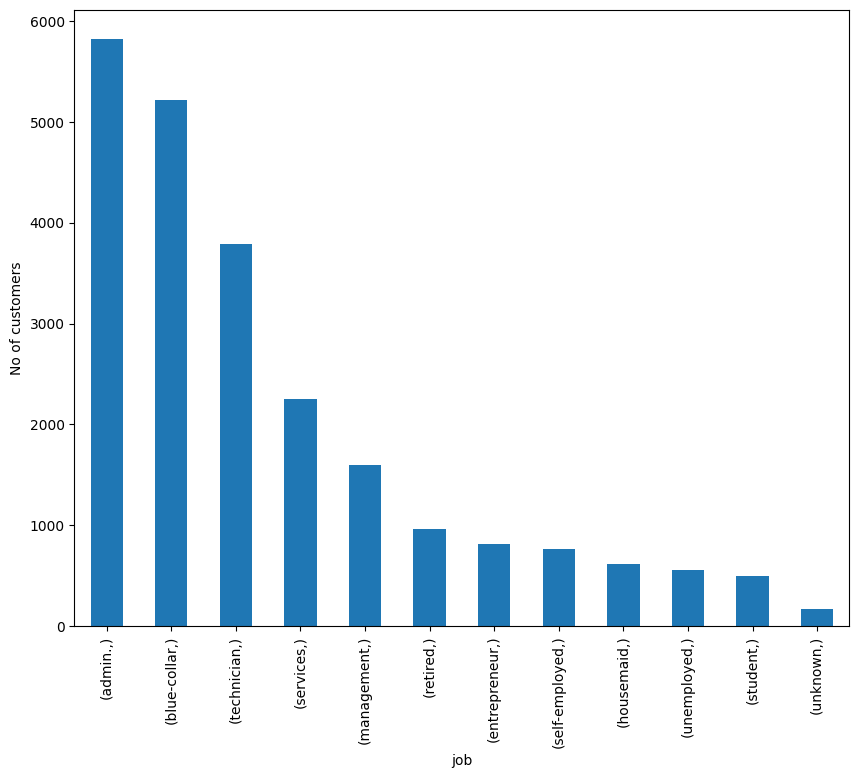

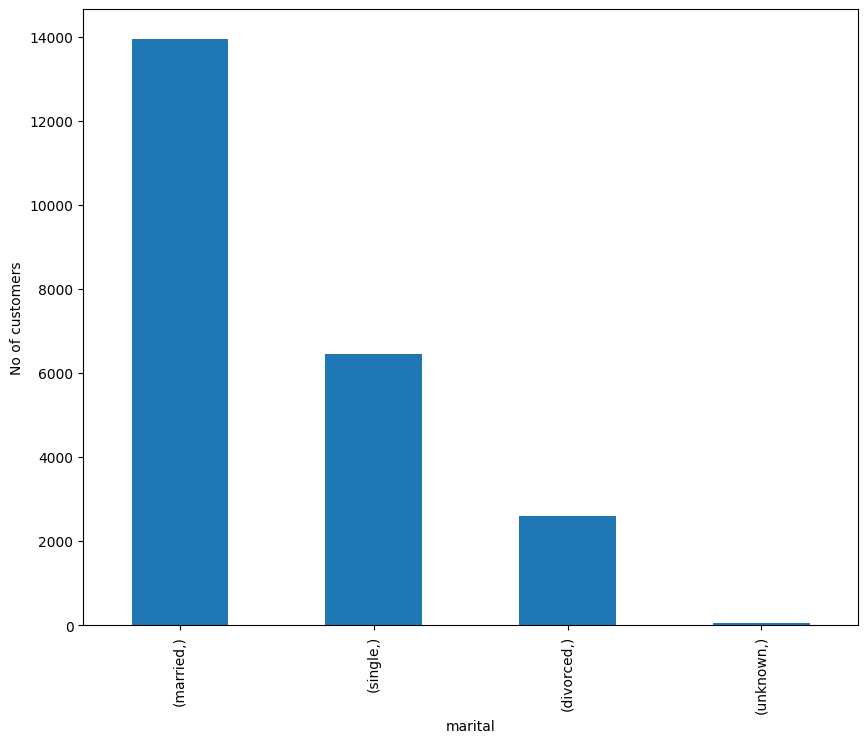

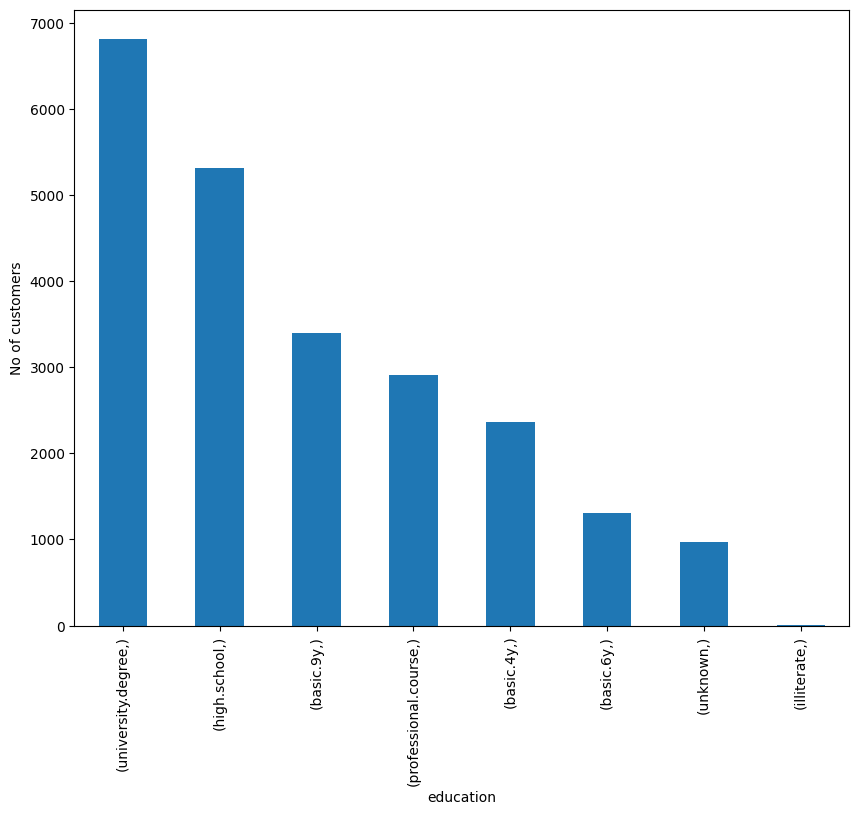

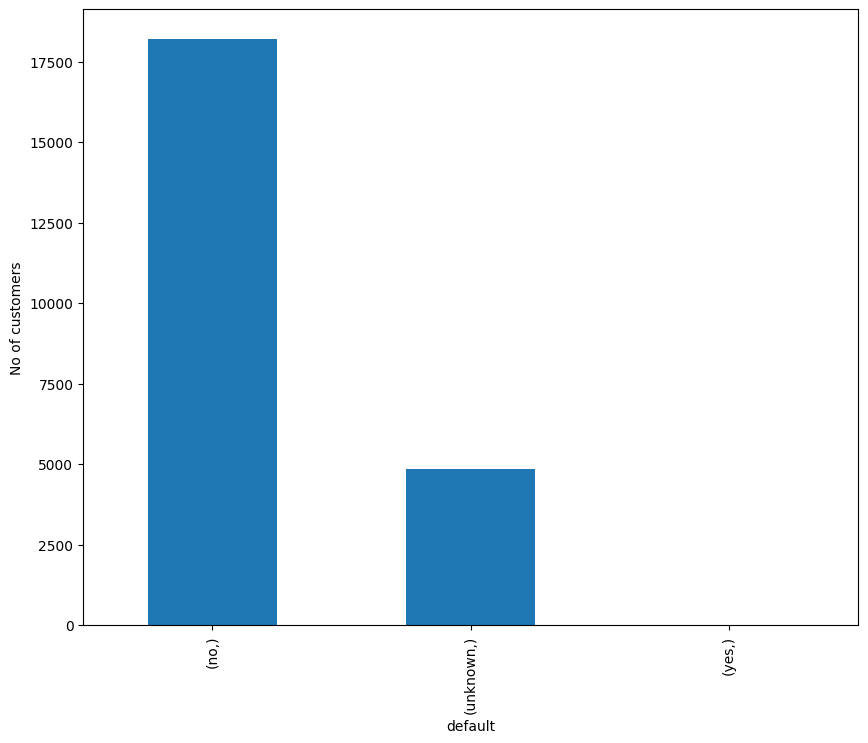

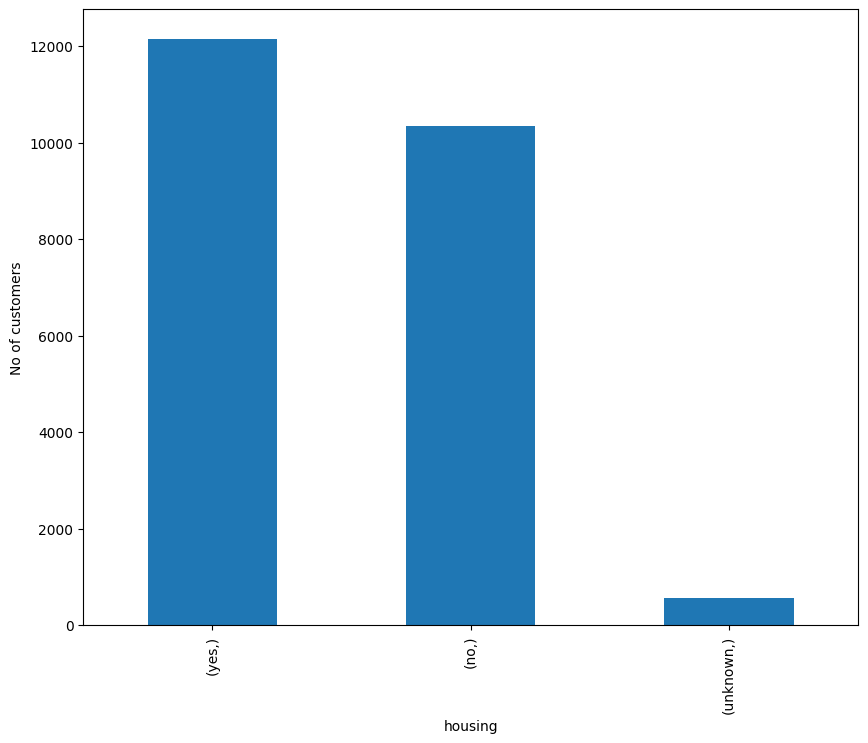

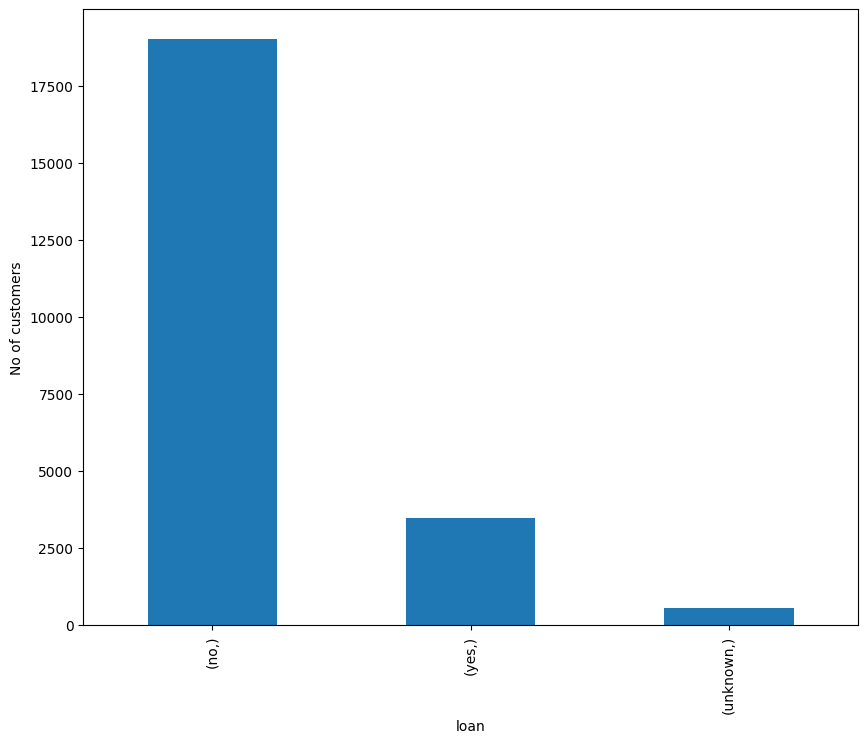

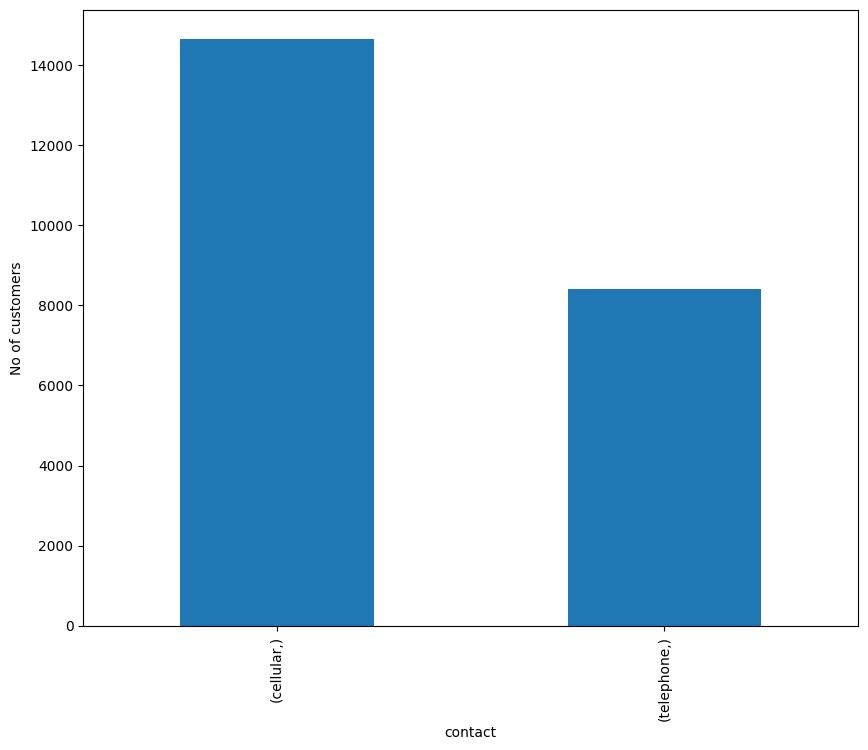

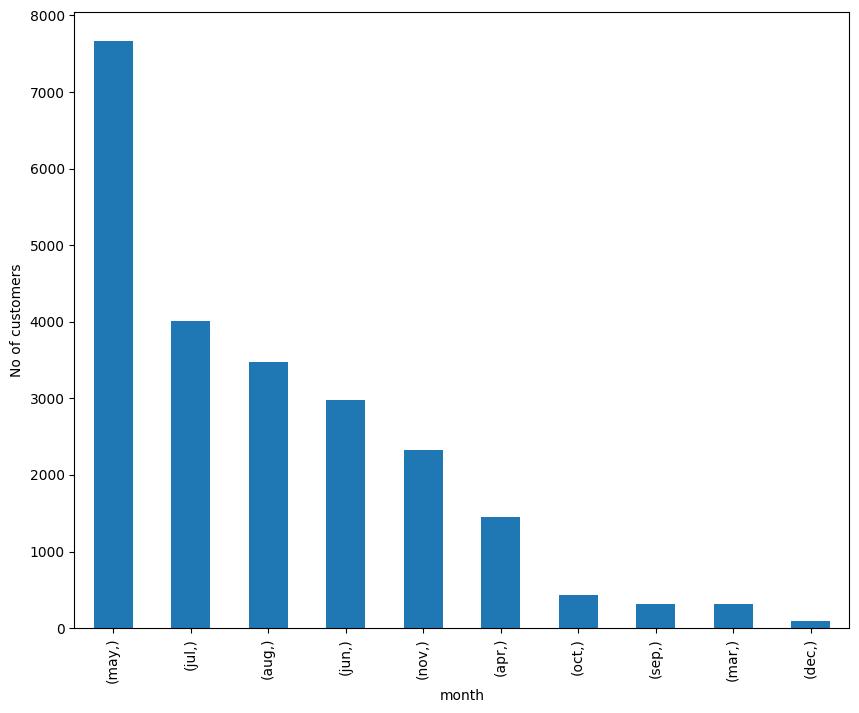

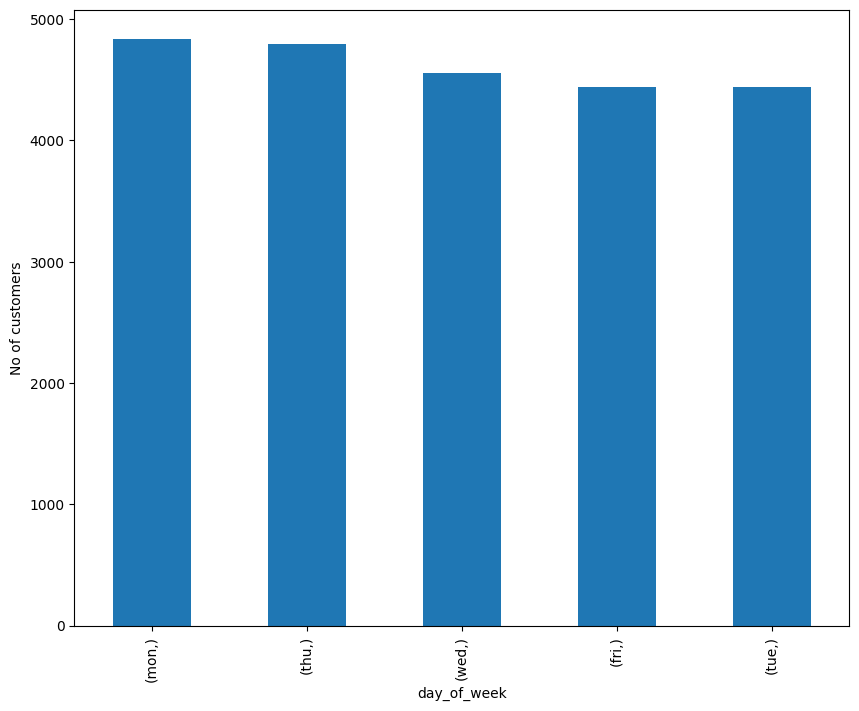

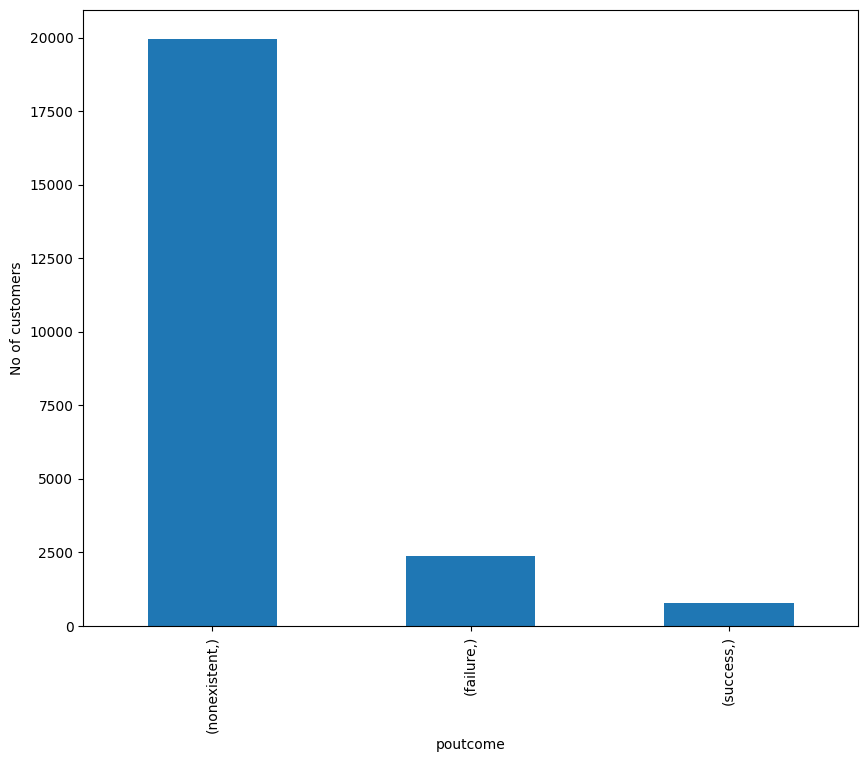

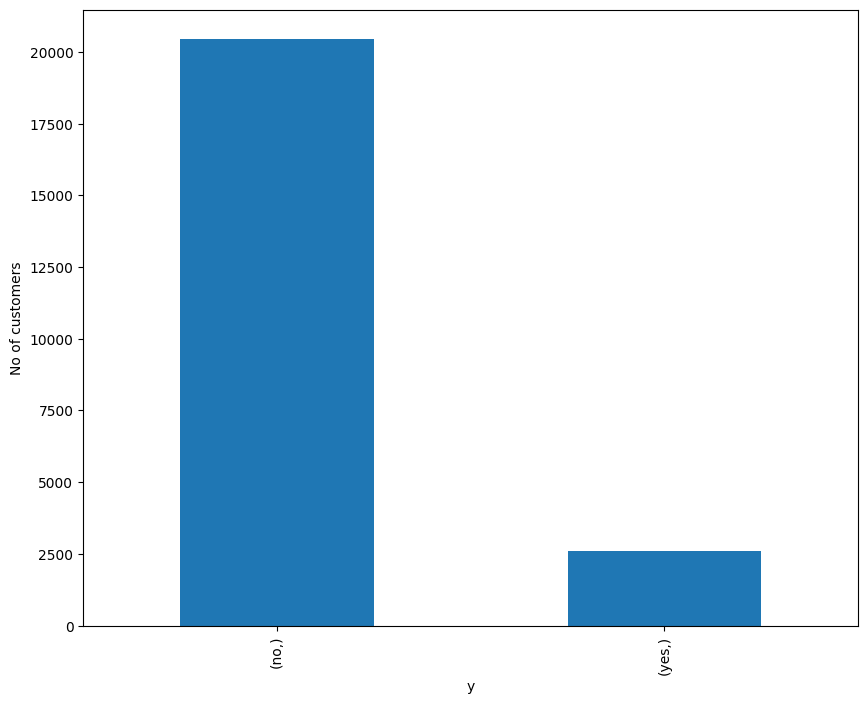

In [6]:
for col in data.select_dtypes(include=['object']).columns:
  data[[col]].value_counts().plot(kind='bar',figsize=(10,8))
  plt.xlabel(col)
  plt.ylabel("No of customers")
  plt.show()

<Axes: >

0.5255582050726209

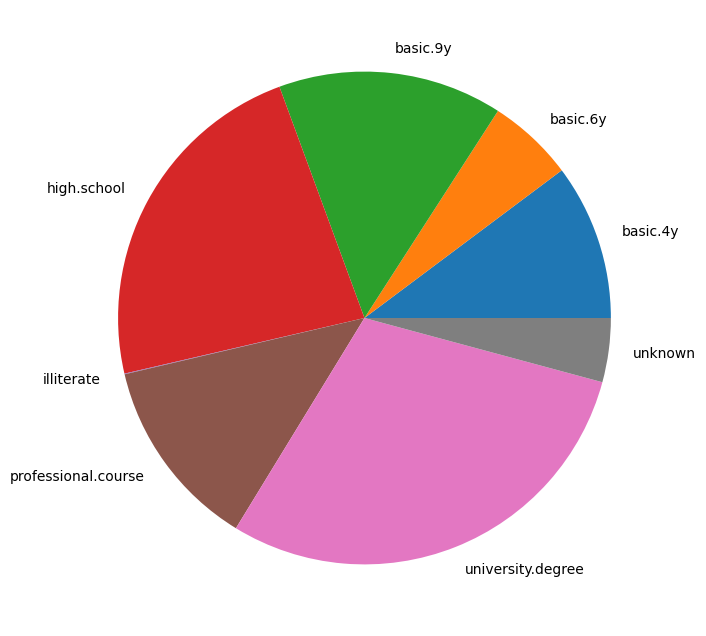

In [7]:
plot = data.groupby(['education']).size().plot.pie(figsize=(10,8))
edu_perc = (data.education.value_counts()['university.degree'] + data.education.value_counts()['high.school'] )/ data.shape[0] 
display(plot, edu_perc)



*   majority of customers are married
*   half of customers have obtained a high school diploma or university degree
*   a third of customers were last contacted in may 
*   majority of customers don't have a credit in default or a personal loan
*   ratio of having a house loan is almost 50:50



## Bivariate data visualization - categorical columns

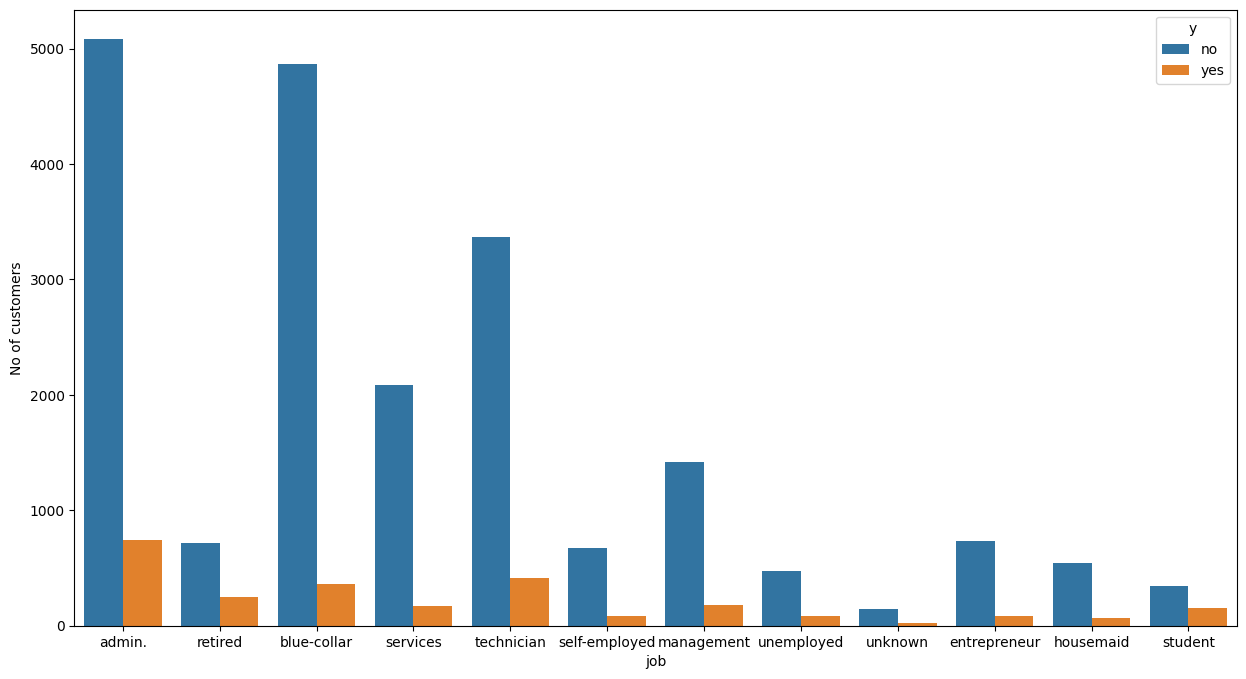

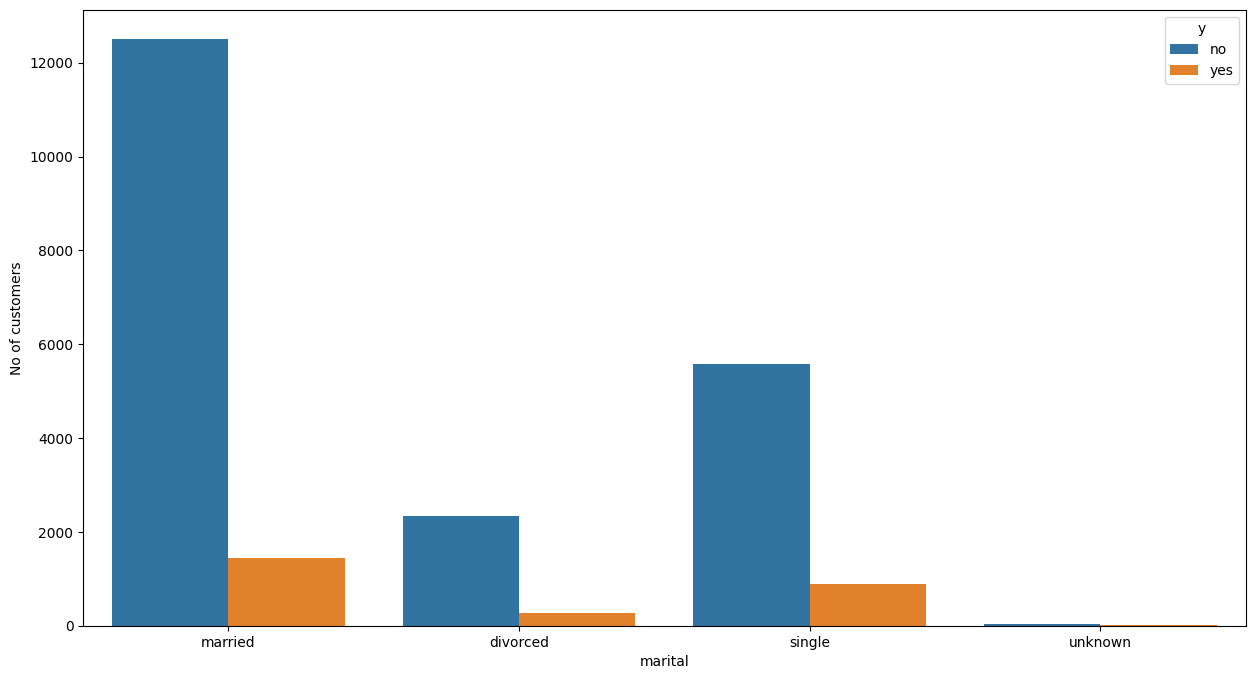

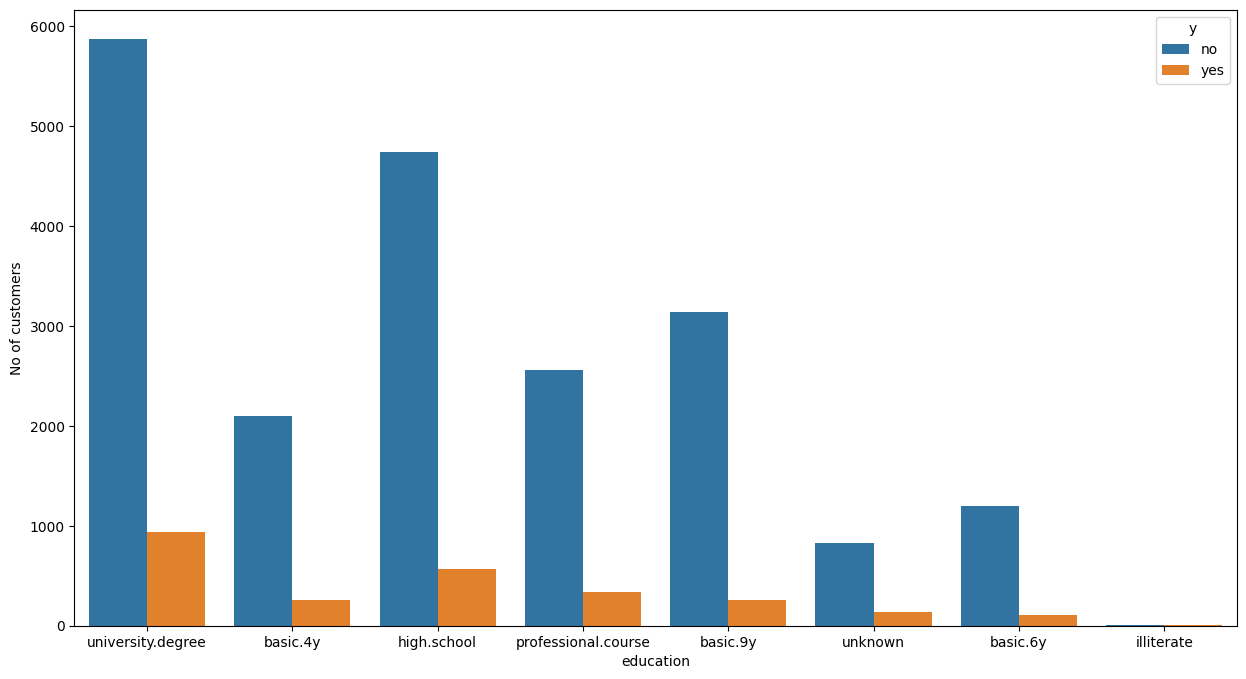

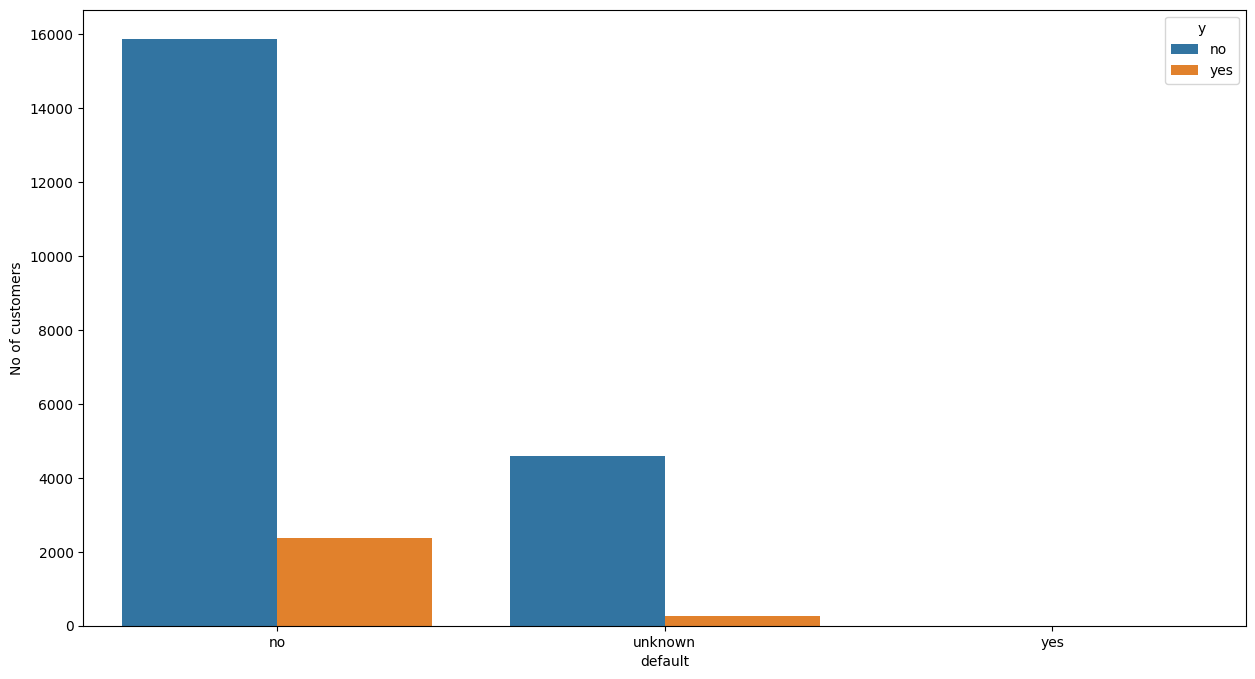

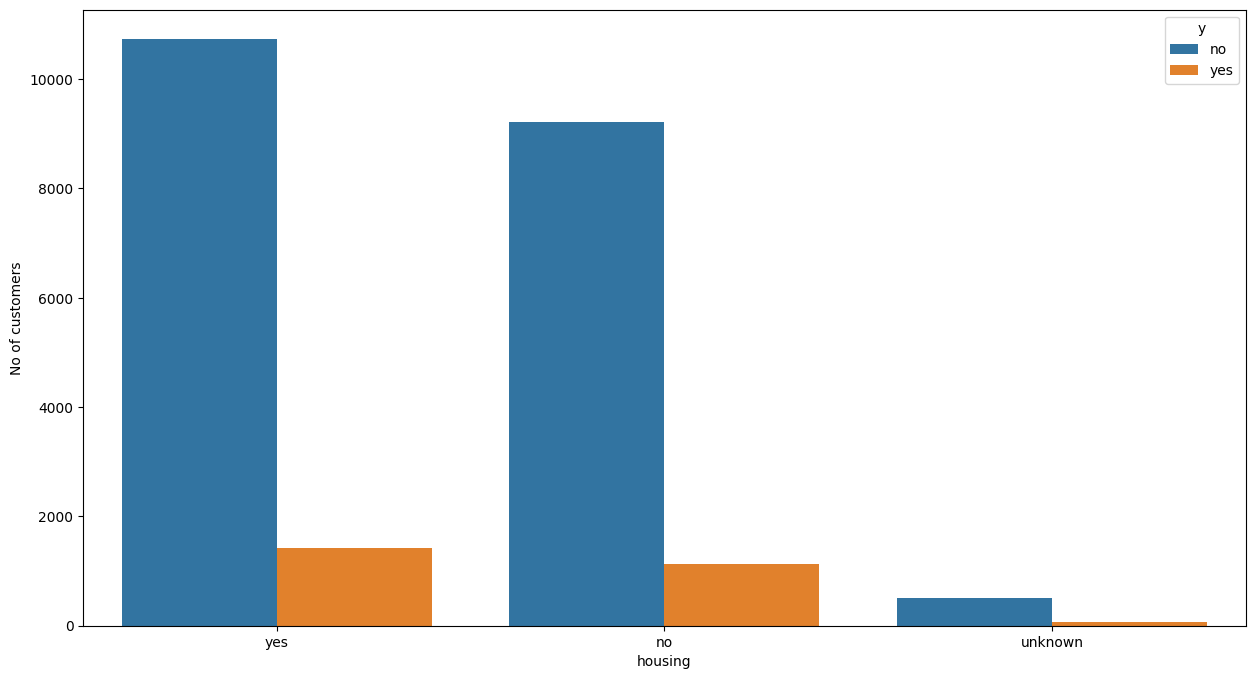

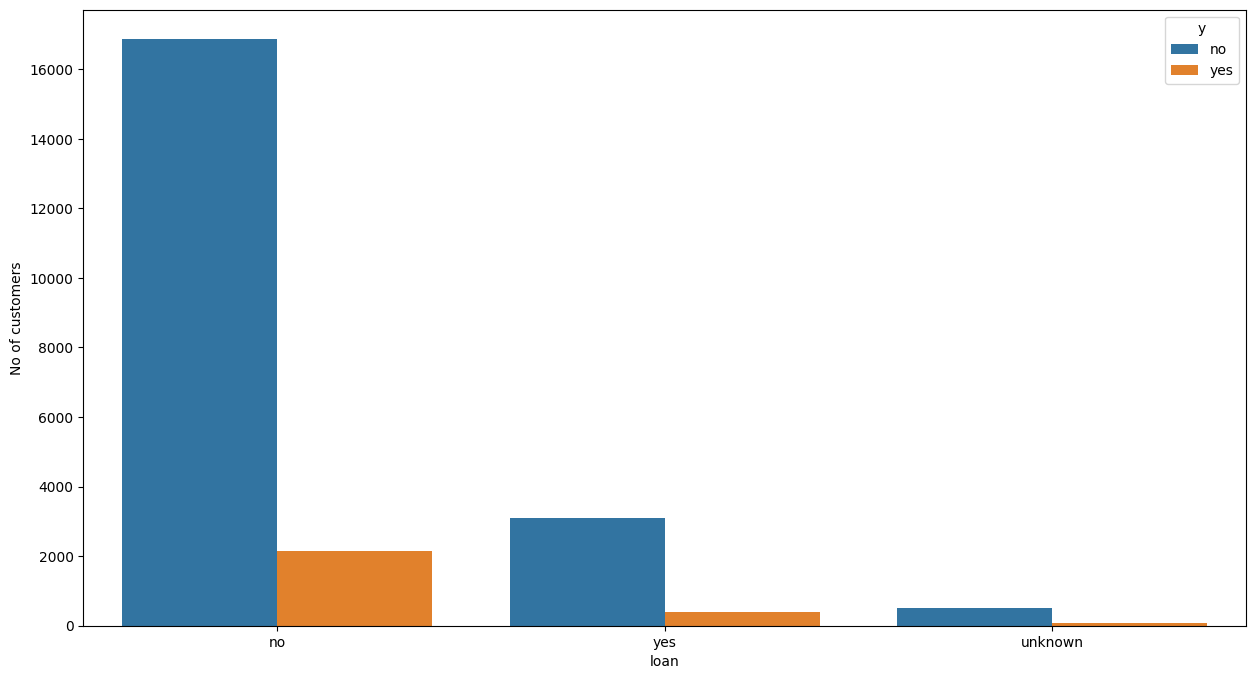

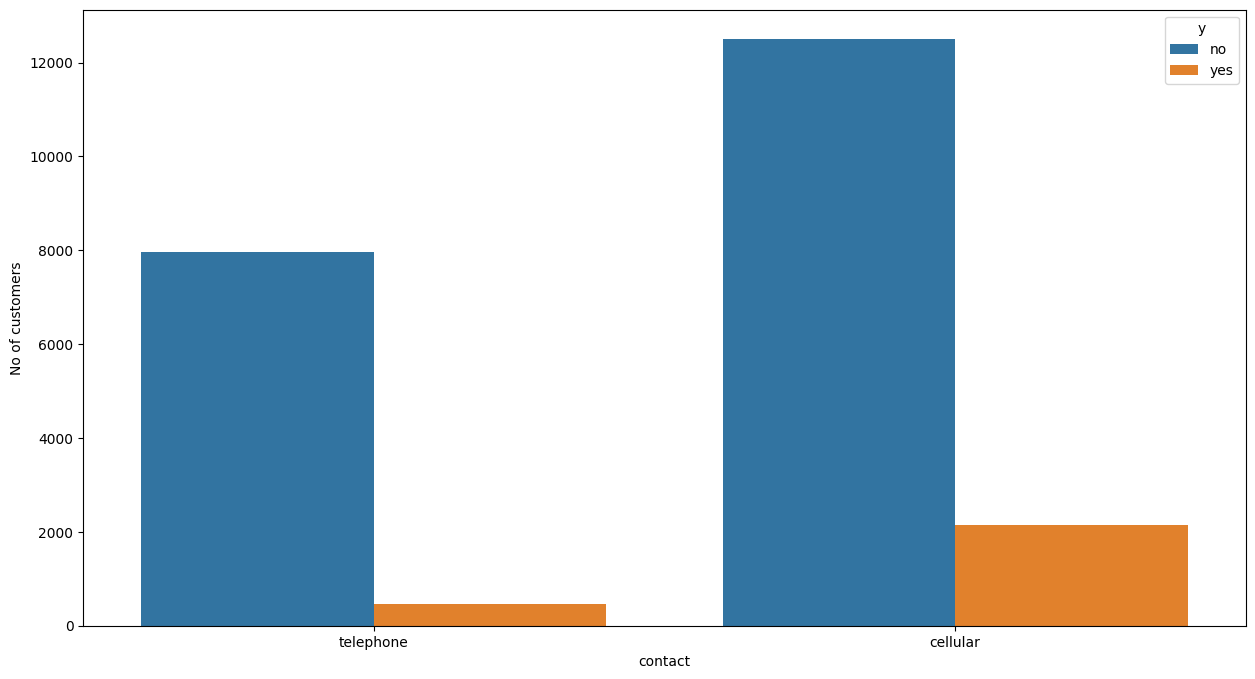

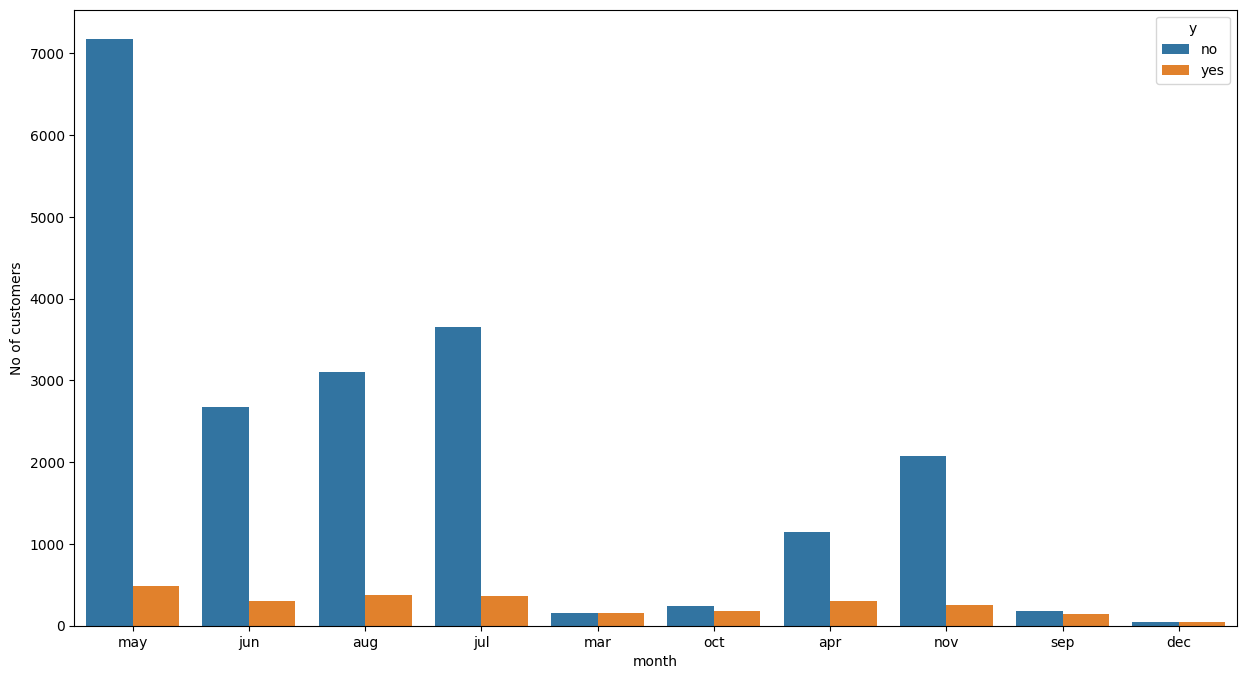

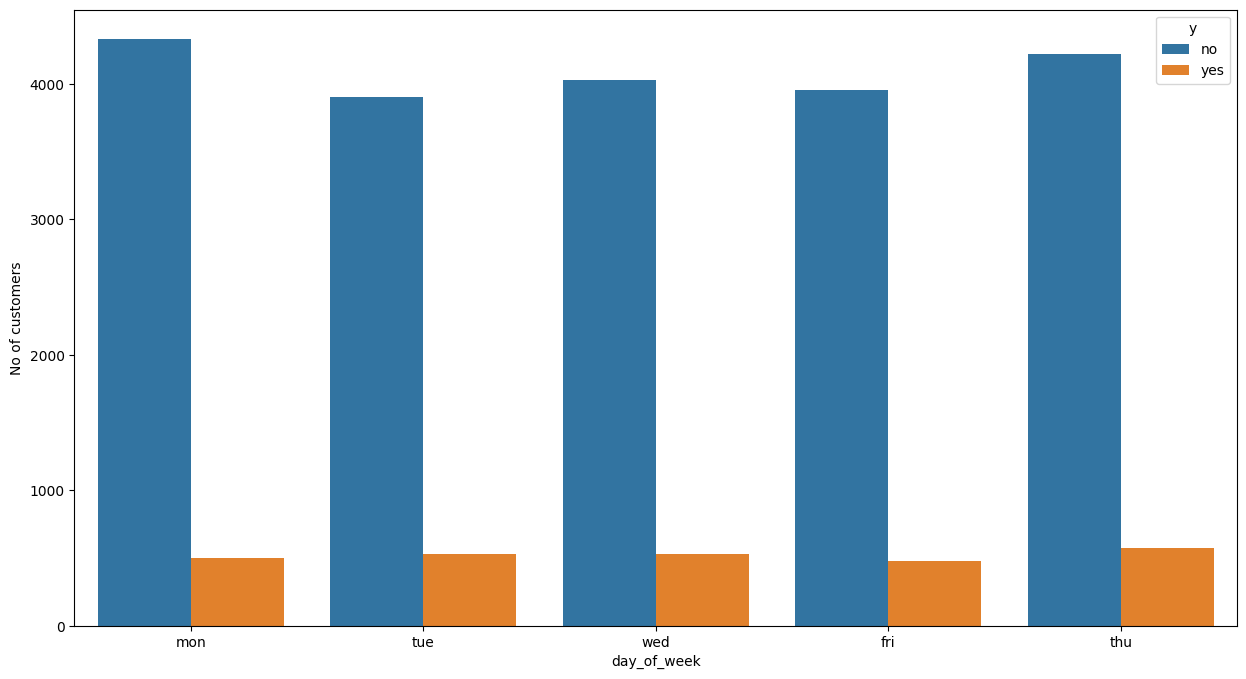

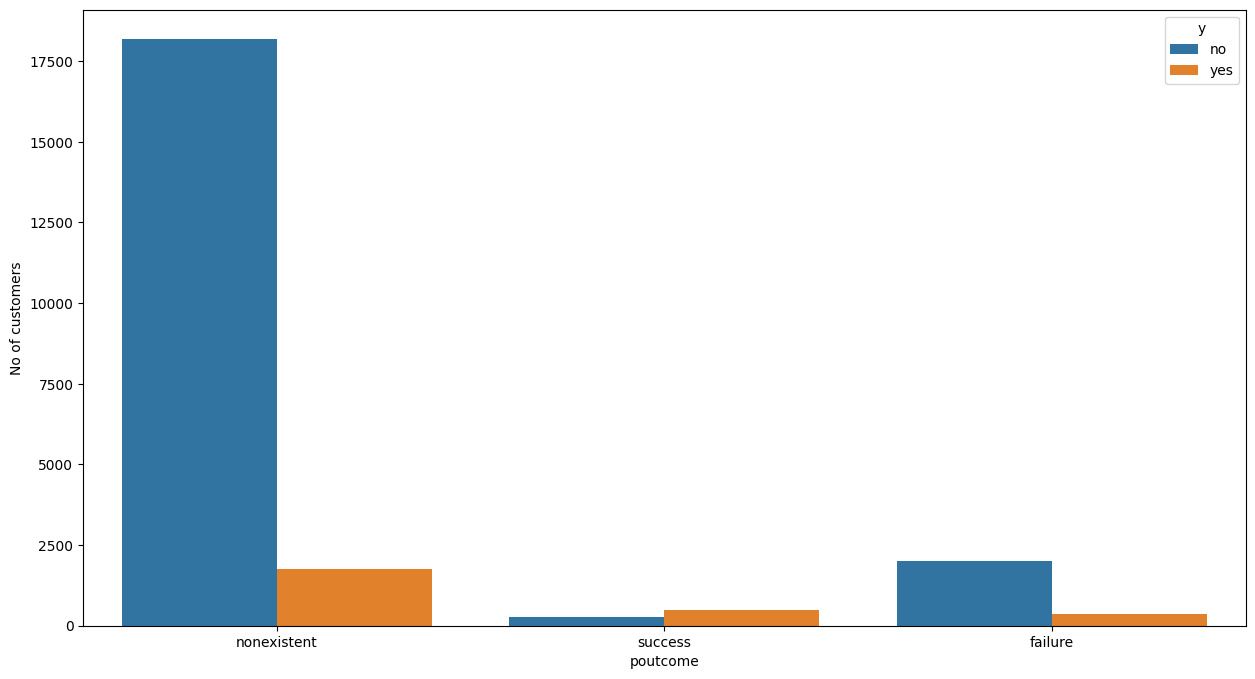

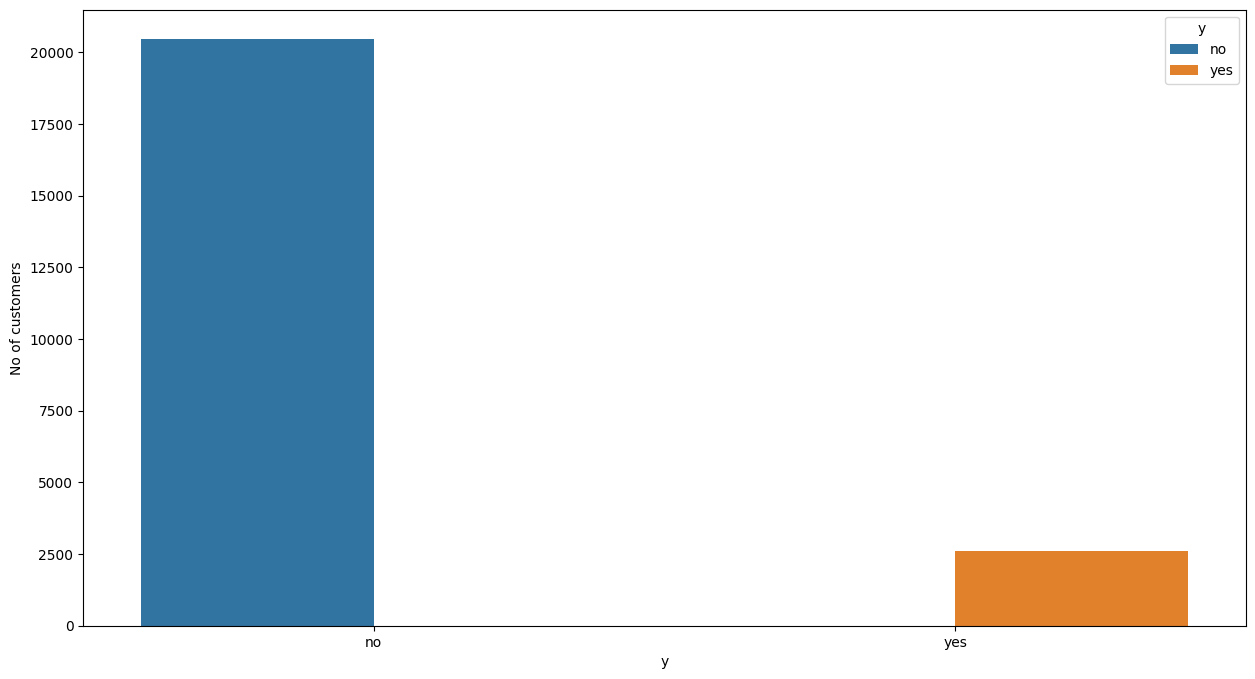

In [8]:
for col in data.select_dtypes(include=['object']).columns:
  plt.figure(figsize=(15,8))
  sns.countplot(x=data[col], hue=data["y"])
  plt.xlabel(col)
  plt.ylabel("No of customers")
  plt.show()

## Data visualization - numerical columns

<Axes: >

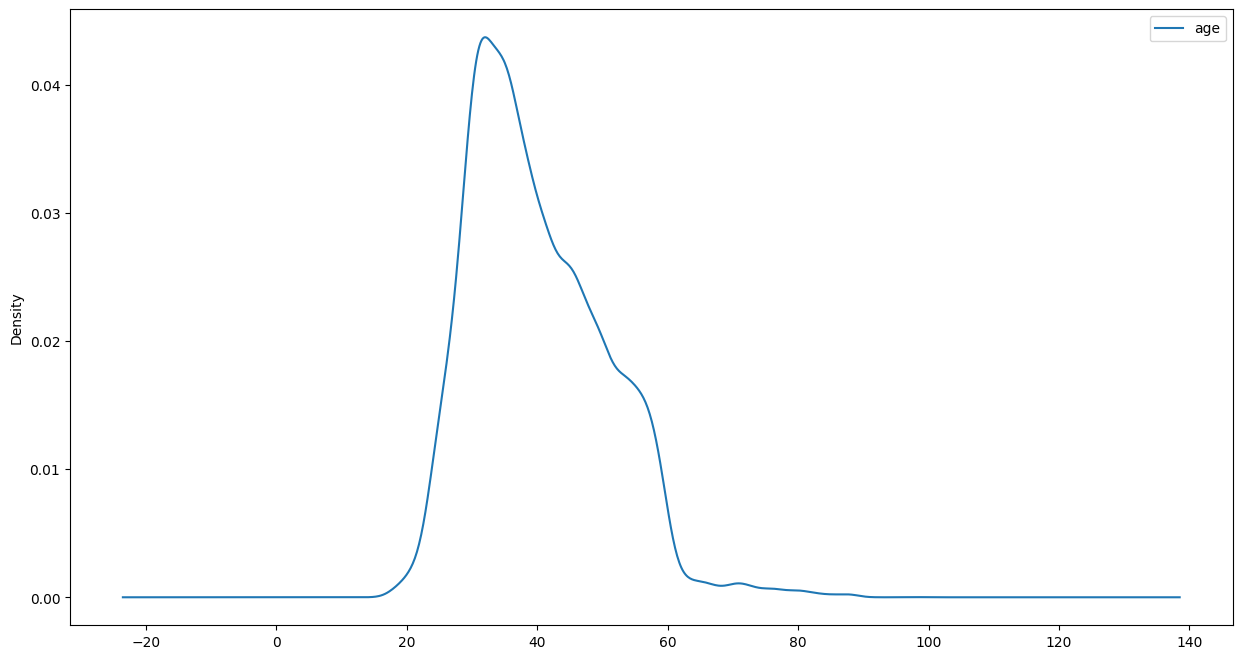

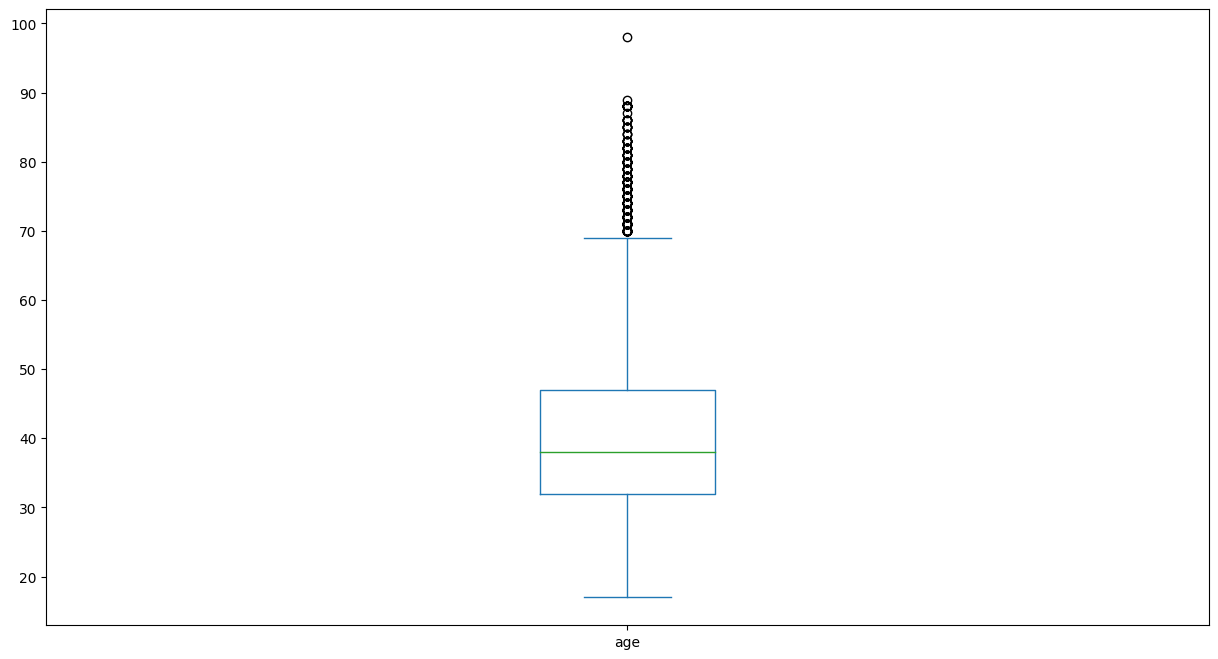

In [9]:
data[['age']].plot.kde(figsize=(15,8))
data[['age']].plot.box(figsize=(15,8))

<Axes: >

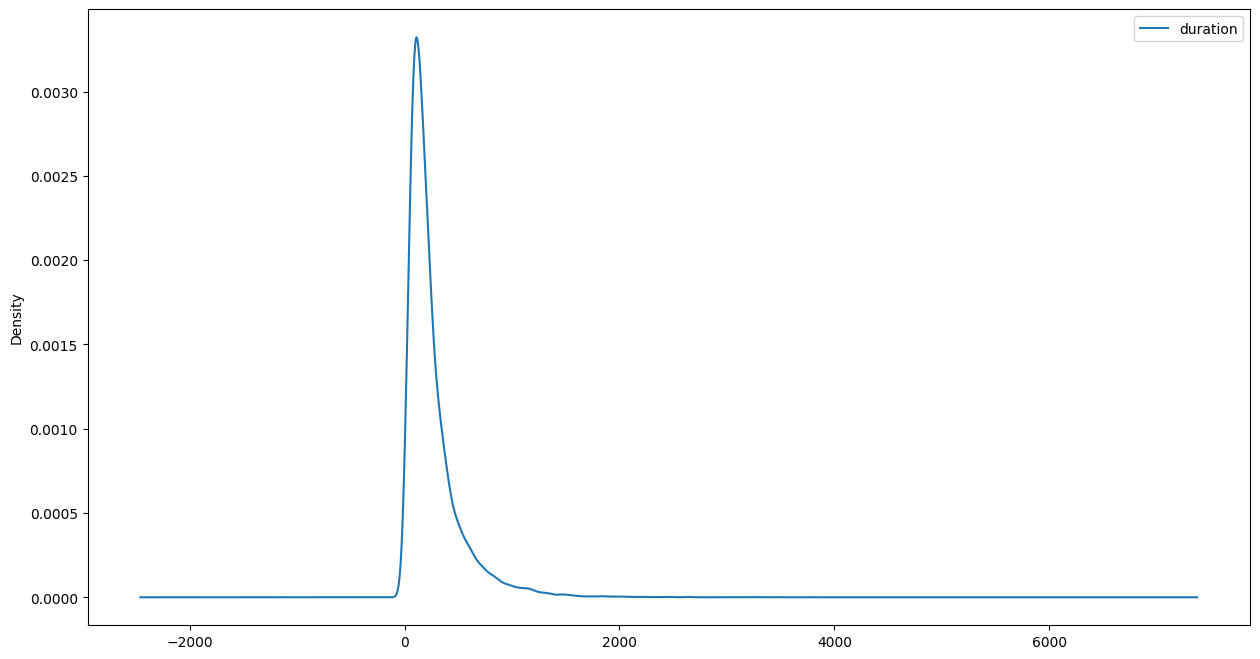

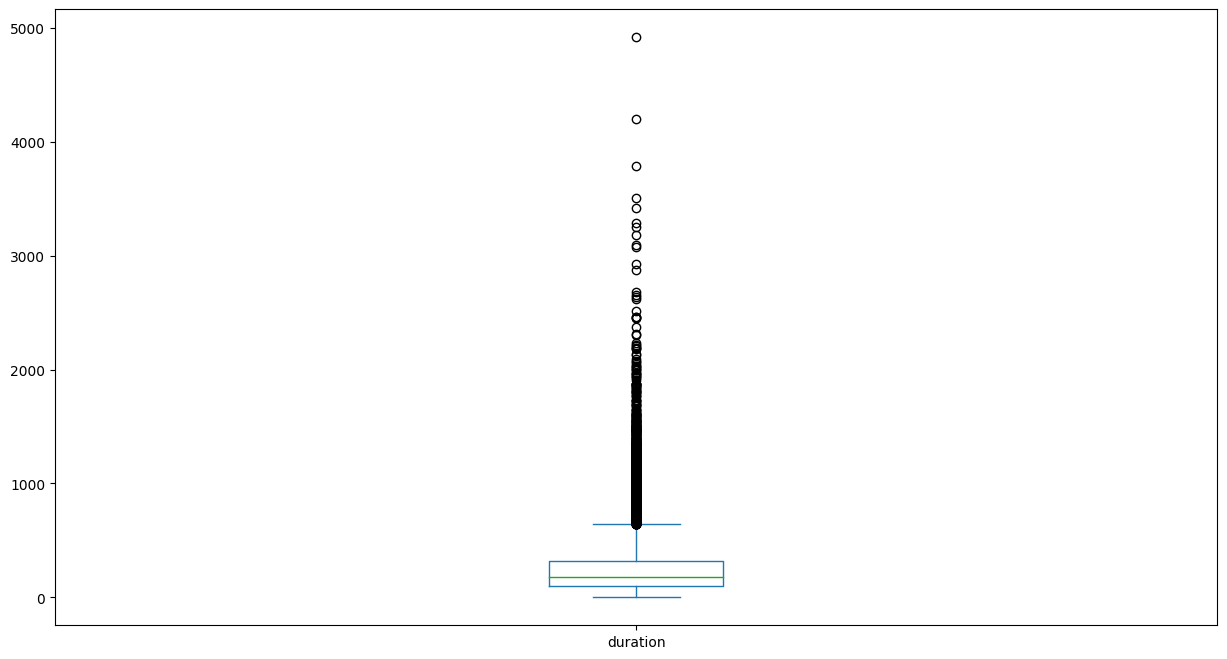

In [10]:
data[['duration']].plot.kde(figsize=(15,8))
data[['duration']].plot.box(figsize=(15,8))


<Axes: >

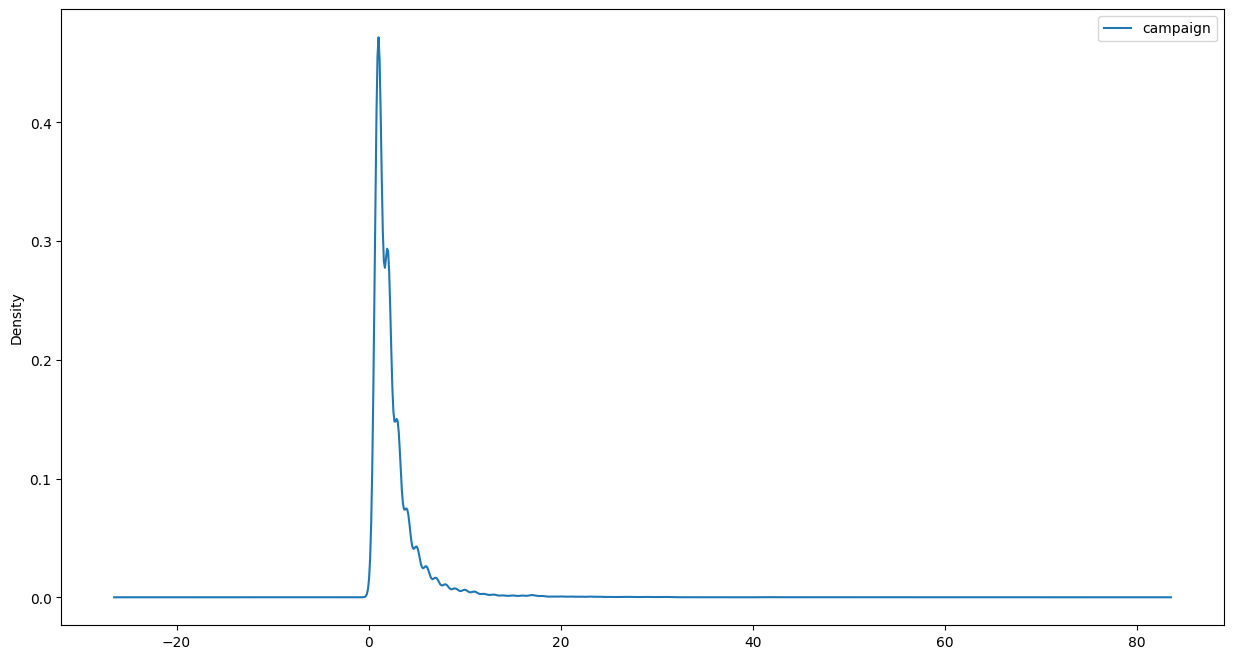

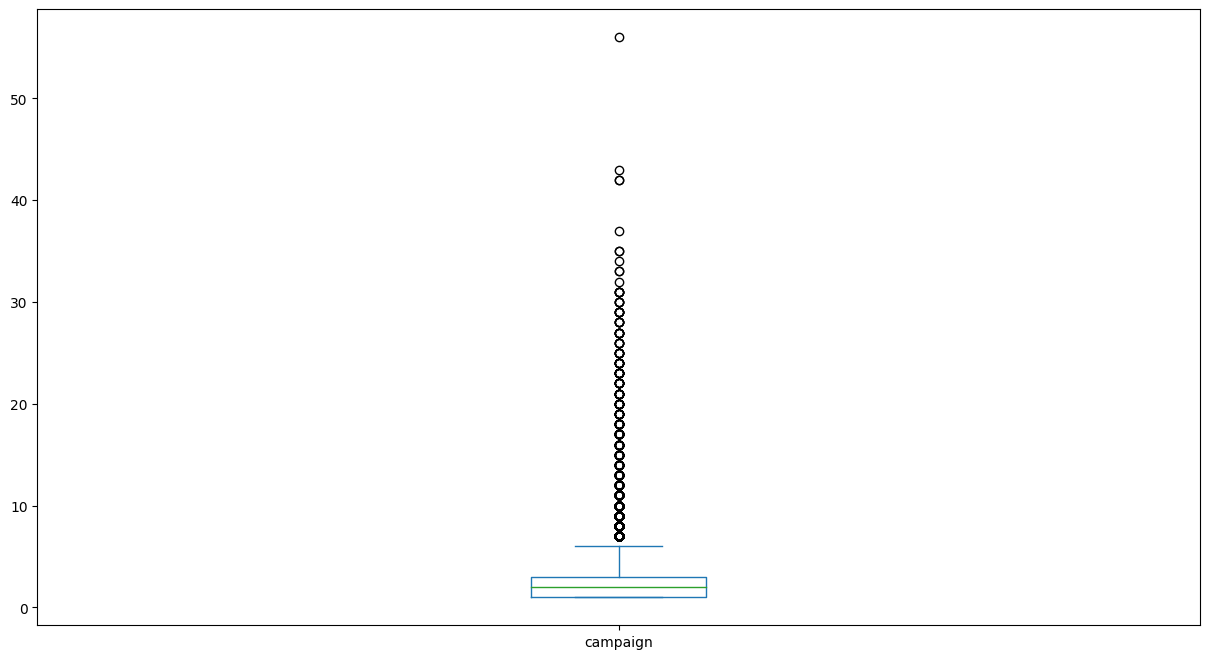

In [11]:
data[['campaign']].plot.kde(figsize=(15,8))
data[['campaign']].plot.box(figsize=(15,8))


<Axes: >

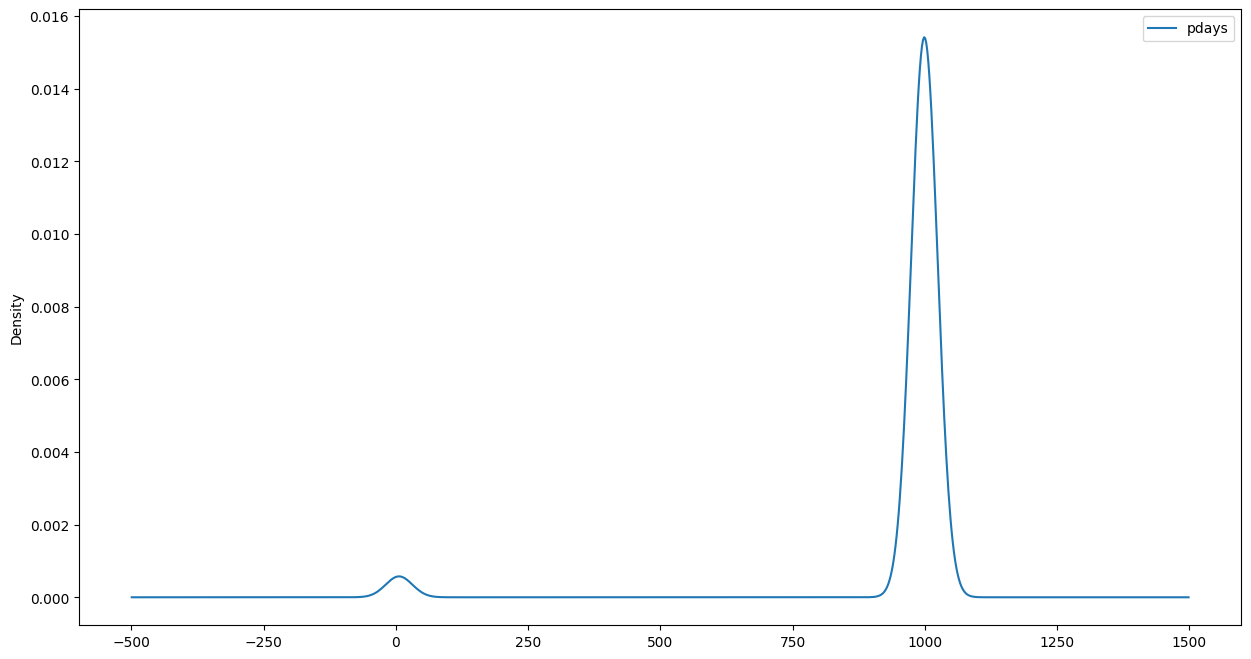

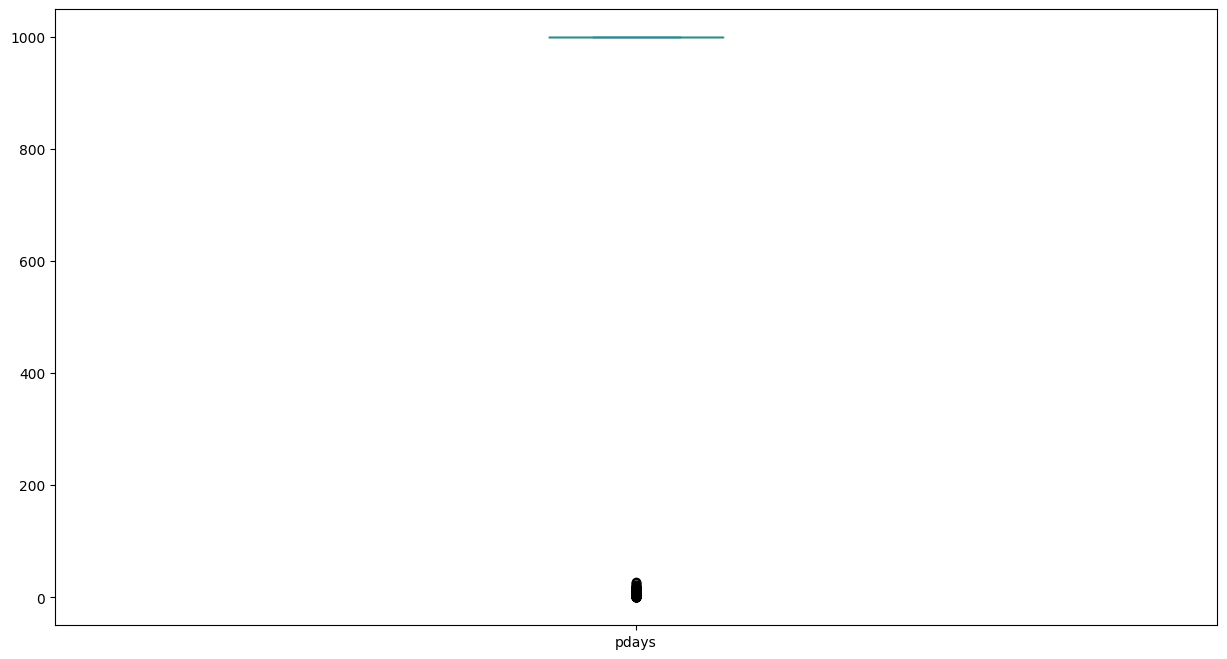

In [12]:
data[['pdays']].plot.kde(figsize=(15,8))
data[['pdays']].plot.box(figsize=(15,8))


<Axes: >

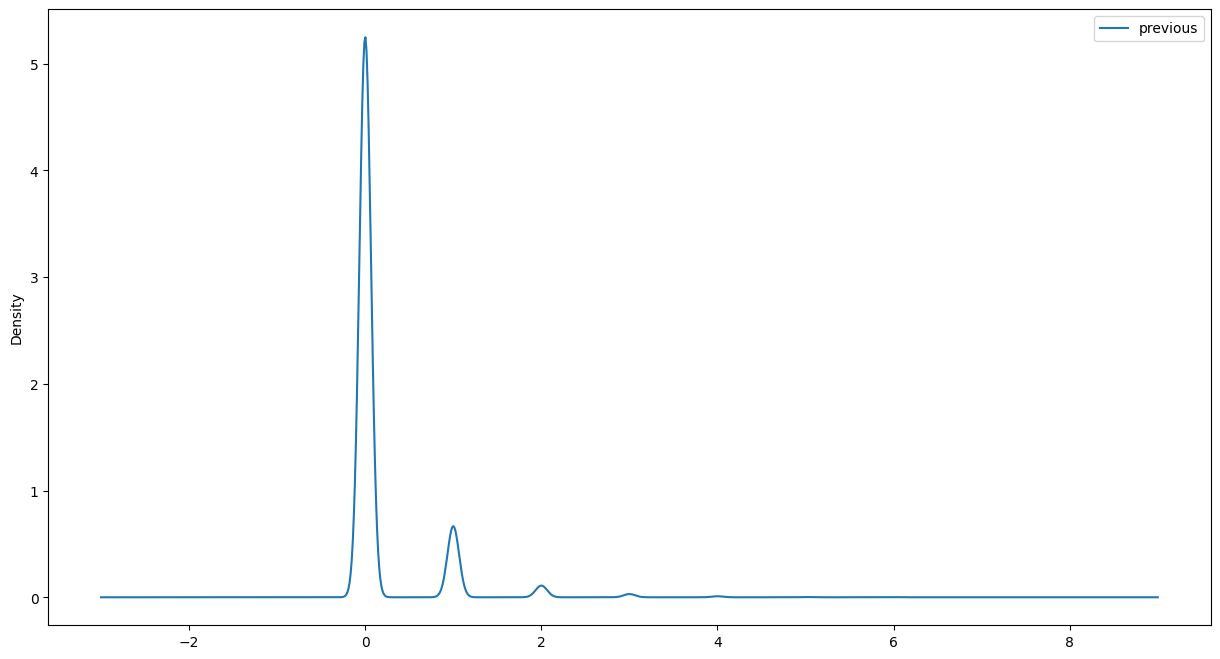

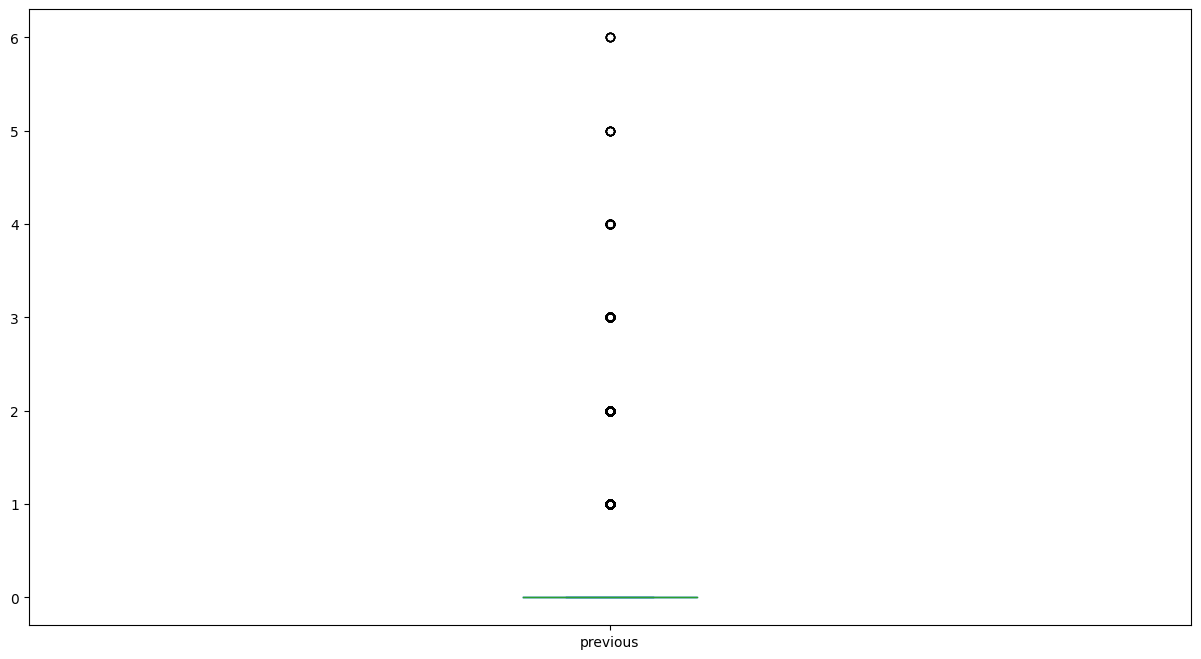

In [13]:
data[['previous']].plot.kde(figsize=(15,8))
data[['previous']].plot.box(figsize=(15,8))



*   Numerical columns contain outliers. Their distributions are skewed
*   **pdays** and **previous** concetrate mostly around one value, so it is most likely fine to leave them out



In [14]:
dropped_cols = data[['pdays','previous']]
data = data.drop(['pdays','previous'],axis=1)

In [15]:
data[['age','duration', 'campaign']].describe()

,age,duration,campaign
count,23065.000000,23065.000000,23065.000000
mean,40.029829,257.543204,2.548016
std,10.376897,261.206897,2.763601
min,17.000000,0.000000,1.000000
25%,32.000000,102.000000,1.000000
50%,38.000000,179.000000,2.000000
75%,47.000000,318.000000,3.000000
max,98.000000,4918.000000,56.000000


## Handling outliers

Firstly let's double check the normality of numerical columns 

In [16]:
from scipy.stats import kstest
num_cols = ['age','duration', 'campaign']
df_data = zip(num_cols, [kstest(data[x], 'norm') for x in num_cols])
normality_df = pd.DataFrame(df_data).T
normality_df.rename(columns=normality_df.iloc[0], inplace = True)
normality_df.drop(normality_df.index[0], inplace = True)
normality_df

,age,duration,campaign
1,"(1.0, 0.0)","(0.9996214828878005, 0.0)","(0.8413447460685429, 0.0)"


p-values are less than 0.05, so the data cannot be assumed to be normal

I want to find out just how many outliers there are in each numerical column

In [17]:
data[num_cols].describe()

,age,duration,campaign
count,23065.000000,23065.000000,23065.000000
mean,40.029829,257.543204,2.548016
std,10.376897,261.206897,2.763601
min,17.000000,0.000000,1.000000
25%,32.000000,102.000000,1.000000
50%,38.000000,179.000000,2.000000
75%,47.000000,318.000000,3.000000
max,98.000000,4918.000000,56.000000


In [18]:
outlier_df = pd.DataFrame(index = ['IQR', 'lower', 'upper', '%'])
outlier_df

""
IQR
lower
upper
%


In [19]:
for col in num_cols:
  IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
  lower_boundary = data[col].quantile(0.25) - 1.5 * IQR
  upper_boundary = data[col].quantile(0.75) + 1.5 * IQR
  perc = data[(data[col] > upper_boundary) | (data[col] < lower_boundary)][col].sum() / data.shape[0]
  ser = pd.Series([IQR, lower_boundary, upper_boundary, perc])
  ser.index = outlier_df.index
  outlier_df[col] = ser

In [20]:
outlier_df

,age,duration,campaign
IQR,15.000000,216.000000,2.000000
lower,9.500000,-222.000000,-2.000000
upper,69.500000,642.000000,6.000000
%,0.868242,69.270453,0.629699


In [21]:
data.y.value_counts()


no     20455
yes     2610
Name: y, dtype: int64

I will replace the outliers with the boundaries

In [22]:
data.loc[ data['age'] < outlier_df.iloc[1]['age'],'age' ] =  outlier_df.iloc[1]['age']
data.loc[ data['age'] > outlier_df.iloc[2]['age'],'age' ] =  outlier_df.iloc[2]['age']

data.loc[ data['duration'] > outlier_df.iloc[2]['duration'],  'duration'] =  outlier_df.iloc[2]['duration']

data.loc[ data['campaign'] > outlier_df.iloc[2]['campaign'],'campaign'  ] =  outlier_df.iloc[2]['campaign']


In [23]:
data.y.value_counts()


no     20455
yes     2610
Name: y, dtype: int64

In [24]:
data[num_cols].describe()

,age,duration,campaign
count,23065.000000,23065.000000,23065.000000
mean,39.951051,234.032473,2.258574
std,10.106874,176.645984,1.537087
min,17.000000,0.000000,1.000000
25%,32.000000,102.000000,1.000000
50%,38.000000,179.000000,2.000000
75%,47.000000,318.000000,3.000000
max,69.500000,642.000000,6.000000


## Encoding

In [25]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
label = LabelEncoder()
onehot = OneHotEncoder()
ordinal = OrdinalEncoder()

In [26]:
cat_cols = list(data.select_dtypes(include=['object']).columns)
cat_cols.remove('y')


In [27]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

Encoding the target value to be either 0 or a 1 

In [28]:
data.y = label.fit_transform(data.y)
data.y.value_counts()

0    20455
1     2610
Name: y, dtype: int64

C:\Users\lasic\AppData\Local\Temp\ipykernel_20796\2975194400.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt='.1f')


<Figure size 2500x1500 with 0 Axes>

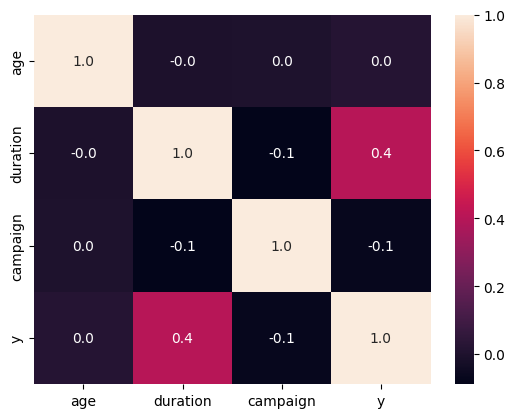

<Figure size 2500x1500 with 0 Axes>

In [29]:
sns.heatmap(data.corr(), annot=True, fmt='.1f')
plt.figure(figsize=(25,15))

In [30]:

from sklearn.model_selection import train_test_split
from category_encoders.leave_one_out import LeaveOneOutEncoder
from imblearn.combine import SMOTETomek

loo = LeaveOneOutEncoder(return_df=True,random_state=1)
y = data.y
X = data.drop('y',axis=1)
X = loo.fit_transform(X, y)


<Figure size 2500x1500 with 0 Axes>

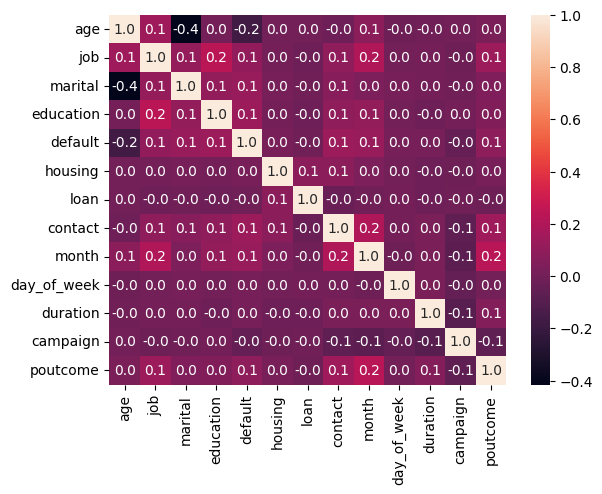

<Figure size 2500x1500 with 0 Axes>

In [31]:
sns.heatmap(X.corr(), annot=True, fmt='.1f')
plt.figure(figsize=(25,15))

In [32]:
smote = SMOTETomek(random_state=1)
X_sm, y_sm = smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, random_state=1)

# Modeling

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc

In [34]:
lr = LogisticRegression(random_state=1, max_iter = 1000)
svc = SVC(random_state=1)
rfc = RandomForestClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
models = [lr,svc,rfc,xgb]

In [35]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
15374,28.0,0.077162,0.137776,0.106255,0.129509,0.116645,0.111207,0.146641,0.063316,0.119675,6,5,0.088521
28965,42.0,0.077162,0.103985,0.106255,0.129509,0.116645,0.111207,0.146641,0.063316,0.115840,77,2,0.148070
16124,54.0,0.114375,0.100656,0.138139,0.129509,0.116645,0.113395,0.054902,0.063316,0.119132,49,1,0.088521
25376,39.0,0.111111,0.103985,0.075994,0.129509,0.116645,0.113395,0.146641,0.106713,0.107730,150,4,0.088521
15442,29.0,0.109379,0.137776,0.117769,0.129509,0.116645,0.113395,0.146641,0.089935,0.107730,274,3,0.088521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,28.0,0.126954,0.103985,0.106255,0.129509,0.116645,0.113395,0.146641,0.063316,0.115840,293,3,0.088521
24655,56.0,0.077162,0.103985,0.075994,0.051785,0.108845,0.113395,0.054902,0.063316,0.103826,379,1,0.088521
7385,30.0,0.307071,0.137622,0.106066,0.129454,0.108748,0.113342,0.146573,0.063185,0.107505,226,2,0.654305
17335,27.0,0.307071,0.137622,0.106066,0.129454,0.108748,0.113342,0.054783,0.429577,0.119450,187,1,0.088471


In [36]:
metrics_df = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
for model in models:
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  col = pd.Series(data=[accuracy_score(pred, y_test), precision_score(pred, y_test), recall_score(pred, y_test),f1_score(pred, y_test)],
                  index= ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  name=type(model).__name__)
  metrics_df[type(model).__name__] = col

c:\Users\lasic\Desktop\endtoendDS\bank-client\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
y_train.value_counts()

0    15352
1     1946
Name: y, dtype: int64

In [38]:
metrics_df

,LogisticRegression,SVC,RandomForestClassifier,XGBClassifier
Accuracy,0.900468,0.884862,1.0,1.0
Precision,0.280120,0.000000,1.0,1.0
Recall,0.659574,0.000000,1.0,1.0
F1-Score,0.393235,0.000000,1.0,1.0


# Metrics

Text(33.22222222222222, 0.5, 'Predicted Values')

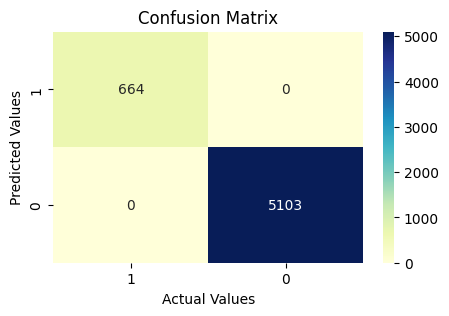

In [39]:
tn, fp , fn, tp = confusion_matrix(y_test,rfc.predict(X_test)).ravel()

plt.figure(figsize = (5,3)) 

sns.heatmap(np.array([tp, fp , fn, tn]).reshape(2,2),xticklabels = [1,0],
            yticklabels = [1,0],fmt='d', annot = True,cmap="YlGnBu")

plt.title('Confusion Matrix')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Modeling and metrics for the resampled sets

In [40]:
lr_sm = LogisticRegression(random_state=1, max_iter = 1000)
svc_sm = SVC(random_state=1)
rfc_sm = RandomForestClassifier(random_state=1)
xgb_sm = XGBClassifier(random_state=1)
models_sm = [lr_sm,svc_sm,rfc_sm,xgb_sm]

In [41]:
X_sm_test

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
4388,31.000000,0.126954,0.137776,0.138139,0.129509,0.108845,0.113395,0.146641,0.102315,0.119675,99,1,0.088521
30270,26.859528,0.126782,0.137622,0.137992,0.129454,0.116562,0.113342,0.146573,0.426372,0.119425,126,1,0.088471
21780,50.000000,0.126954,0.100656,0.106255,0.129509,0.116645,0.113395,0.146641,0.106713,0.107730,430,1,0.088521
9270,31.000000,0.114375,0.137776,0.138139,0.129509,0.108845,0.113395,0.054902,0.063316,0.119675,169,1,0.088521
7460,36.000000,0.111111,0.137776,0.138139,0.129509,0.108845,0.111207,0.146641,0.107750,0.115840,127,2,0.088521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31290,35.000000,0.125528,0.134845,0.137992,0.129454,0.116562,0.113342,0.146573,0.199578,0.108446,642,2,0.088471
6317,26.000000,0.109115,0.137622,0.137992,0.129454,0.116562,0.113342,0.146573,0.089686,0.107505,642,3,0.654305
2105,37.000000,0.068734,0.103985,0.109839,0.129509,0.116645,0.113395,0.054902,0.063316,0.103826,59,4,0.088521
3932,54.000000,0.126954,0.103985,0.138139,0.129509,0.116645,0.113395,0.146641,0.107750,0.119132,201,2,0.088521


In [42]:
metrics_df = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
for model in models_sm:
  model.fit(X_sm_train, y_sm_train)
  pred = model.predict(X_sm_test)
  col = pd.Series(data=[accuracy_score(pred, y_sm_test), precision_score(pred, y_sm_test), recall_score(pred, y_sm_test),f1_score(pred, y_sm_test)],
                  index= ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  name=type(model).__name__)
  metrics_df[type(model).__name__ + '_sm'] = col

In [43]:
metrics_df

,LogisticRegression_sm,SVC_sm,RandomForestClassifier_sm,XGBClassifier_sm
Accuracy,0.854218,0.740933,1.0,1.0
Precision,0.865286,0.727496,1.0,1.0
Recall,0.845014,0.745065,1.0,1.0
F1-Score,0.855030,0.736176,1.0,1.0


Text(33.22222222222222, 0.5, 'Predicted Values')

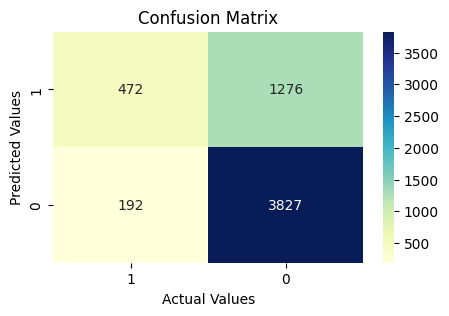

In [44]:
tn, fp , fn, tp = confusion_matrix(y_test,svc_sm.predict(X_test)).ravel()

plt.figure(figsize = (5,3)) 

sns.heatmap(np.array([tp, fp , fn, tn]).reshape(2,2),xticklabels = [1,0],
            yticklabels = [1,0],fmt='d', annot = True,cmap="YlGnBu")

plt.title('Confusion Matrix')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

We can see that SMOTe improved our scores

In [45]:
X_sm_train.shape

(29448, 13)

Preprocessing steps taken to achieve these scores



*   Dropped **pdays** and **previous**
*   Replaced outliers with boundary values in  **age**, **duration**, **campaign**
*   Encoded no -> 0; yes -> 1 in **y** column
*   Encoded the rest of categorical columns with LeaveOneOut
*   Performed oversampling using SMOTETomek 
*   Modeling


In [46]:
data_test.drop(['pdays','previous'],axis=1,inplace=True)

In [47]:
data_test.loc[ data_test['age'] < outlier_df.iloc[1]['age'],'age' ] =  outlier_df.iloc[1]['age']
data_test.loc[ data_test['age'] > outlier_df.iloc[2]['age'],'age' ] =  outlier_df.iloc[2]['age']

data_test.loc[ data_test['duration'] > outlier_df.iloc[2]['duration'],  'duration'] =  outlier_df.iloc[2]['duration']

data_test.loc[ data_test['campaign'] > outlier_df.iloc[2]['campaign'],'campaign'  ] =  outlier_df.iloc[2]['campaign']

In [48]:
data_test.y = label.transform(data_test.y)

In [49]:
data_test_y = data_test.y
data_test_X = data_test.drop('y',axis=1)
data_test_X = loo.transform(data_test_X, data_test_y)


In [50]:
data_test_X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
2888,47.0,0.109379,0.137776,0.117769,0.051785,0.108845,0.113395,0.054902,0.063316,0.115840,27,1,0.088521
8059,53.0,0.114375,0.137776,0.117769,0.051785,0.108845,0.113395,0.146641,0.089935,0.115840,76,5,0.088521
17137,50.0,0.068543,0.103913,0.117424,0.051578,0.108748,0.113342,0.146573,0.106282,0.118923,283,1,0.088471
9336,41.0,0.109379,0.103985,0.117769,0.129509,0.108845,0.113395,0.146641,0.107750,0.119675,269,1,0.088521
24096,35.0,0.126954,0.103985,0.117769,0.129509,0.108845,0.113395,0.054902,0.102315,0.103826,62,1,0.088521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21407,33.0,0.098160,0.103985,0.138139,0.129509,0.116645,0.111207,0.146641,0.106713,0.119132,141,2,0.088521
1183,34.0,0.068734,0.103985,0.082055,0.051785,0.116645,0.113395,0.146641,0.063316,0.119675,306,2,0.148070
13249,44.0,0.068734,0.103985,0.075994,0.051785,0.116645,0.113395,0.146641,0.063316,0.103826,144,2,0.148070
3750,48.0,0.126954,0.103985,0.138139,0.129509,0.108845,0.113395,0.146641,0.089935,0.107730,54,1,0.088521


In [51]:
test_metrics_df = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
for model in models_sm:
  pred = model.predict(data_test_X)
  col = pd.Series(data=[accuracy_score(pred, data_test_y), precision_score(pred, data_test_y), recall_score(pred, data_test_y),f1_score(pred, data_test_y)],
                  index= ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  name=type(model).__name__)
  test_metrics_df[type(model).__name__ + '_sm'] = col
test_metrics_df

,LogisticRegression_sm,SVC_sm,RandomForestClassifier_sm,XGBClassifier_sm
Accuracy,0.838240,0.733637,1.0,1.0
Precision,0.816697,0.728675,1.0,1.0
Recall,0.391815,0.255977,1.0,1.0
F1-Score,0.529568,0.378863,1.0,1.0
